In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import xarray as xr                      
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import glob
from datetime import date, time, datetime 
import pandas as pd 
import netCDF4 as net
from netCDF4 import num2date
import scipy.io
from scipy.io import loadmat
from scipy import interpolate
import datetime as dt

In [8]:
dataset = scipy.io.loadmat('Routine_v020721.mat')
alongtrack = xr.open_dataset('/Users/emmagurcan/Documents/JPL 2021/along-track data/Sentinel3A_NRT_2019_2020.nc')

In [9]:
print(dataset.keys())
print(np.min(dataset['lon']))
x_min = np.min(dataset['lon'])
x_max = np.max(dataset['lon'])
y_min = np.min(dataset['lat'])
y_max = np.max(dataset['lat'])
lon = dataset['lon']
lat = dataset['lat']

dict_keys(['__header__', '__version__', '__globals__', 't', 'lon', 'lat', 'adt2', 'vg2', 'ug2'])
-131.7407407407407


In [10]:
adt = dataset['adt2']
times = dataset['t']  
time_mean = np.mean(adt, axis = 2)

/Users/emmagurcan/opt/anaconda3/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


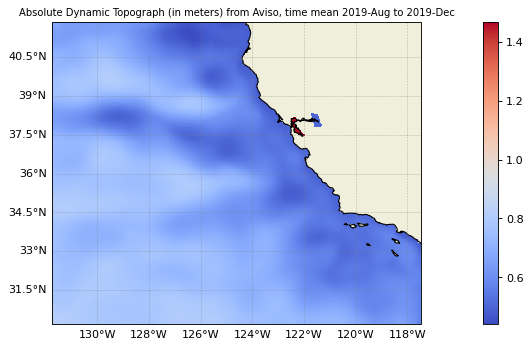

In [11]:
fig = plt.figure(figsize = (20, 5), dpi = 80)
ax = fig.add_subplot(projection=ccrs.PlateCarree())
ax.set_title('Absolute Dynamic Topograph (in meters) from Aviso, time mean 2019-Aug to 2019-Dec', fontsize = 9)
ax.set_extent([x_min, x_max, y_min, y_max], crs = ccrs.PlateCarree())
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                   linewidth=.5, color='gray', alpha=0.5, linestyle='--') # include gridlines on map
gl.top_labels = False     # don't want to plot labels on top side
gl.right_labels = False 
f = ax.pcolormesh(lon, lat, time_mean, cmap = 'coolwarm')
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE) 

vmin = 0.4
vmax = 0.9
levels = 5
level_boundaries = np.linspace(vmin, vmax, levels + 1)
plt.colorbar(f)

#plt.clim(0.4, 0.9)

plt.show()

In [12]:
# Function to convert datenum to datetime
def matlab2datetime(matlab_datenum):
    day = dt.datetime.fromordinal(int(matlab_datenum))
    dayfrac = dt.timedelta(days=int(matlab_datenum%1)) - dt.timedelta(days = 366)
    return day + dayfrac

In [13]:
# Function to find index of specific date
def time_idx(year, month, day, times):
    idx = -1
    for time in times:
        idx += 1
        if matlab2datetime(time) == datetime(year, month, day):
            return idx

In [14]:
print(matlab2datetime(times[0]))

2019-08-01 00:00:00


In [15]:
year = 2019
month = 8
day = 1
idx = time_idx(year, month, day, times)
print(idx)

0


In [48]:
def plot_model_at_date(dataset, year, month, day):
    # Determine data to plot
    adt = dataset['adt2']
    times = dataset['t'] 
    idx = time_idx(year, month, day, times)
    plot_data = adt[:, :, idx]
    
    # Determine parameters
    lon = dataset['lon']
    lat = dataset['lat']
    x_min = np.min(lon)
    x_max = np.max(lon)
    y_min = np.min(lat)
    y_max = np.max(lat)
    
    # Create figure
    fig = plt.figure(figsize = (20, 5), dpi = 80)
    ax = fig.add_subplot(projection=ccrs.PlateCarree())
    ax.set_extent([x_min, x_max, y_min, y_max], crs = ccrs.PlateCarree())
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                   linewidth=.5, color='gray', alpha=0.5, linestyle='--') # include gridlines on map
    gl.top_labels = False     # don't want to plot labels on top side
    gl.right_labels = False 
    f = ax.pcolormesh(lon, lat, plot_data, cmap = 'coolwarm', vmin = 0.4, vmax = 0.9)
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE) 
    
    # Colorbar
    fig.colorbar(f)
    
    # Title
    title = "Absolute Dynamic Topograph (in meters) from Model on {year}-{month}-{day}"
    ax.set_title(title.format(year = int(year), month = int(month), day = int(day)))
    
    plt.show()

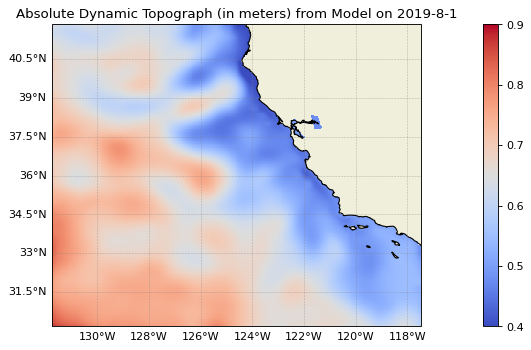

In [49]:
plot_model_at_date(dataset, 2019, 8, 1)

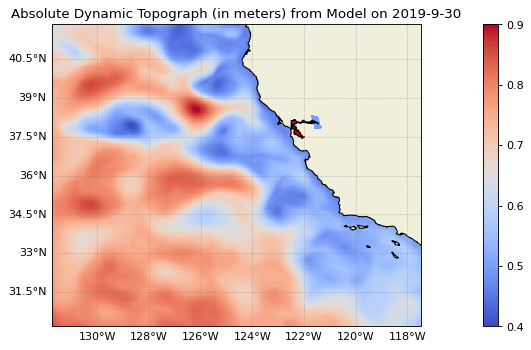

In [50]:
plot_model_at_date(dataset, 2019, 9, 30)

In [19]:
def plot_alongtrack_data(dataset, data, title):
    #determine the long and lat
    long = dataset['longitude']
    lat = dataset['latitude']
    
    # determine coordinates
    attributes = dataset.attrs
    x_min = attributes['longitude_min']
    x_max = attributes['longitude_max']
    y_min = attributes['latitude_min']
    y_max = attributes['latitude_max']
    
    # set figure axis
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree()) # define the map projection
    ax.set_extent([x_min, x_max, y_min, y_max], crs=ccrs.PlateCarree())
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                   linewidth=.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False 
    
    # plot data
    plt.scatter(long, lat, c=data, s=5, cmap = 'coolwarm')
    
    # coastlines
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    
    #colorbar
    plt.colorbar(shrink = 0.5)
    
    # set title
    plt.title(title)
    
    plt.show()

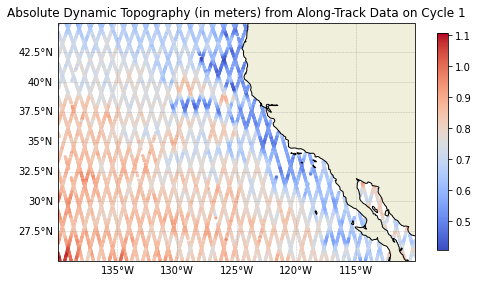

In [20]:
#ground tracks plot
alongtrack_adt = alongtrack['adt']
alongtrack_lon = alongtrack['longitude']
alongtrack_lat = alongtrack['latitude']
adt_day_1 = alongtrack_adt[1, :, :]
title = 'Absolute Dynamic Topography (in meters) from Along-Track Data on Cycle 1'

plot_alongtrack_data(alongtrack, adt_day_1, title)

In [21]:
# INTERPOLATION

In [269]:
# function that modifies the alongtrack dataset to be the same dimensions (latitude and longitude)
# as the model dataset
def data_slice(alongtrack, model):
    # determine min and max of model dataset
    model_min = np.min(model)
    model_max = np.max(model)
    
    # create empty np array
    new_alongtrack = np.empty((342, 72))
    new_alongtrack[:] = np.NaN

    # counters for indexing
    n = 0
    arr_num = 0
    
    # iterate through the arrays in alongtrack dataset
    for arr in alongtrack:
        new_arr = []
        
        # iterate through values in the array
        for val in arr:
            # if the lon or lat falls in between the model min and max, add it to the new alongtrack dataset
            if val.data <= float(model_max) and val.data >= float(model_min):
                new_alongtrack[arr_num][n] = val
                n += 1
        np.append(new_alongtrack, new_arr)
        arr_num += 1
        n = 0
    return new_alongtrack

In [259]:
alongtrack_lon = alongtrack['longitude']
print(alongtrack_lon[0][0])

<xarray.DataArray 'longitude' ()>
array(-131.411335)
Attributes:
    units:     degrees_east
    comments:  east positive, west negative, relative to Greenwich meridian


In [260]:
model = scipy.io.loadmat('Routine_v020721.mat')
model_lon = model['lon']
alongtrack_lon = alongtrack['longitude']
c = data_slice(alongtrack_lon, model_lon)

The model min is -131.7407407407407
The model max is -117.4814814814815


In [261]:
# Extract Variables
model = scipy.io.loadmat('Routine_v020721.mat')

alongtrack_adt = alongtrack['adt']
alongtrack_lon = alongtrack['longitude']
alongtrack_lat = alongtrack['latitude']
alongtrack_time = alongtrack['time']

model_lon = model['lon']
model_lat = model['lat']
model_adt = model['adt2']
model_time = model['t']

z = model_adt[:, :, 0]
x = model_lon
y = model_lat
t = model_time[0]

x_new = data_slice(alongtrack_lon, model_lon)
y_new = data_slice(alongtrack_lat, model_lat)
t_new = model_time[0]

#f = interpolate.interp2d(x, y, z, kind = 'linear')
#znew = f(x_new, y_new)

#fig = figsize(20,5)
#plt.imshow(znew)


The model min is -131.7407407407407
The model max is -117.4814814814815
The model min is 30.164708303700255
The model max is 41.84461032989518


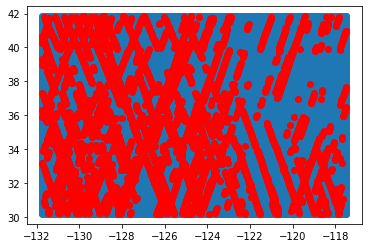

In [267]:
f = plt.scatter(x, y)
plt.scatter(x_new, y_new, color = 'red')

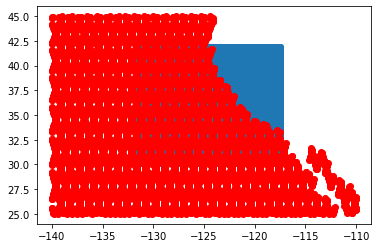

In [268]:
f = plt.scatter(x, y)
plt.scatter(alongtrack_lon, alongtrack_lat, color = 'red')